---

Imports

---

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from sklearn.model_selection import StratifiedShuffleSplit
from torch import nn, optim
from PIL import Image

---

Define Data Source and Transformations

---

In [3]:
data_folder = 'Scan Data/Histopathology'

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_testval = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

---

Load Data

---

In [ ]:
dataset = datasets.ImageFolder(root=data_folder, transform=None)

---

Split, transform and load data to Train, Test and Val

---

In [ ]:
total_samples = len(dataset)
testval_samples = int(total_samples * 0.125)
testval_size = testval_samples
labels = [item[1] for item in dataset.imgs]

train_test_val = StratifiedShuffleSplit(n_splits=1, test_size=testval_size, random_state=42)
test_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

train_indices, testval_indices = next(train_test_val.split(np.zeros(len(labels)), labels))
test_indices, val_indices = next(test_val.split(np.zeros(len(labels)), labels))

train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset,test_indices)
val_subset = Subset(dataset, val_indices)

train_subset.dataset.transform = transform_train
test_subset.dataset.transform = transform_testval
val_subset.dataset.transform = transform_testval

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


---

Load ResNet50 Model and define params

---

In [10]:
model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(num_ftrs, len(dataset.classes))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
device


device(type='cuda')

---

Train Model


---

In [11]:
epochs = 25
history_train = []
history_val = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%',f'Validation Accuracy: {val_accuracy:.2f}%')
    history_train.append(train_accuracy)
    history_val.append(val_accuracy)

Epoch 1/25, Loss: 0.4886, Train Accuracy: 80.87% Validation Accuracy: 89.99%
Epoch 2/25, Loss: 0.2984, Train Accuracy: 88.50% Validation Accuracy: 90.72%
Epoch 3/25, Loss: 0.2369, Train Accuracy: 90.88% Validation Accuracy: 93.36%
Epoch 4/25, Loss: 0.1989, Train Accuracy: 92.45% Validation Accuracy: 94.76%
Epoch 5/25, Loss: 0.1679, Train Accuracy: 93.64% Validation Accuracy: 93.76%
Epoch 6/25, Loss: 0.1468, Train Accuracy: 94.51% Validation Accuracy: 96.74%
Epoch 7/25, Loss: 0.1361, Train Accuracy: 94.91% Validation Accuracy: 97.19%
Epoch 8/25, Loss: 0.1230, Train Accuracy: 95.44% Validation Accuracy: 96.97%
Epoch 9/25, Loss: 0.1183, Train Accuracy: 95.61% Validation Accuracy: 97.36%
Epoch 10/25, Loss: 0.1087, Train Accuracy: 95.96% Validation Accuracy: 97.65%
Epoch 11/25, Loss: 0.1015, Train Accuracy: 96.22% Validation Accuracy: 97.35%
Epoch 12/25, Loss: 0.0947, Train Accuracy: 96.52% Validation Accuracy: 96.68%
Epoch 13/25, Loss: 0.0972, Train Accuracy: 96.40% Validation Accuracy: 97

---

Plot Learning Curve

---

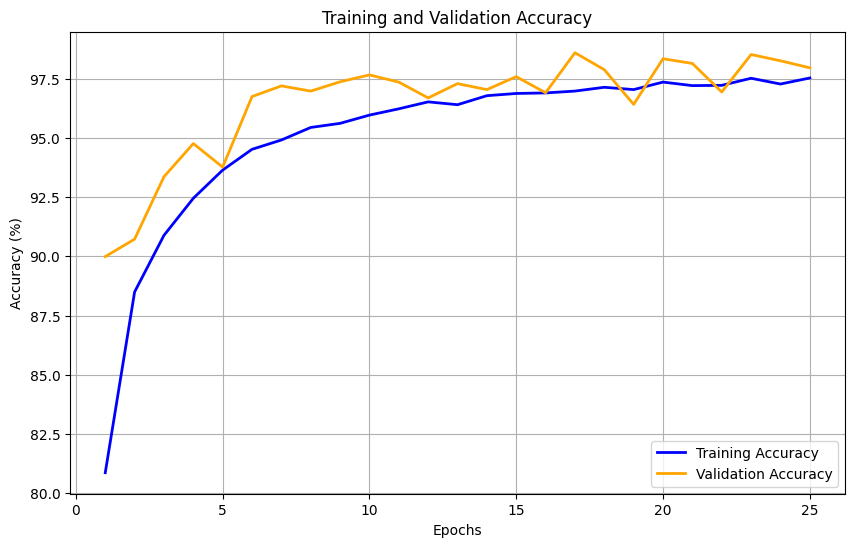

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), history_train, label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
plt.plot(range(1, epochs + 1), history_val, label='Validation Accuracy', color='orange', linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


---

Obtain Val Accuracy

---

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 98.33%


---

Save Model

---

In [18]:
torch.save(model, "Histopathology.pth")